# Import

In [46]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [57]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
#font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 1. 치매 예방을 위한 라이프로그 치매 분류

#### Issue
1. 9천 개의 train data에 대해서만 label(정답값)이 존재, 3만 개의 test data에 대해서는 존재x 

**sample data -> data 와 중복! 필요없음** 

- acticvity : 1000 x 31 
- sleep : 1000 x 36 
- mmse : 16 x 38

**data : 38,419 x 65**

- train : 9,327 x 65
- test : 29,092 x 65  

**column informations**  
크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다. 

- feature column (1 -> 0)
    - EMAIL : participants 148 (471 for test) -> drop 
- activity 걸음거리 (26 -> 24)
    - 2 ~ 28
    - numerical values 
    - 'activity_class_5min', 'activity_met_1min' -> drop (below)
- sleep 수면 (31 -> 26)
    - 28 ~ 58
    - 'sleep_is_longest' : all the values are 1, 본 수면 여부
    - 'sleep_temperature_trend_deviation' : all the values are 99.99, 피부 온도 경향 편차
    - 'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min' -> drop (below)
- converting (5)
    - convert specific columns using 'utf8' 
    - log data, MET log, BLOB ?? 
    - 'activity_class_5min', 'activity_met_1min', 'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min'
    - so, we drop above 5 columns
- time (2 -> 1)
    - summary_date 
    - timezone : 시간장소정보, all null -> drop 
    
So we may use 56 columns for training...
  
For more details https://aihub.or.kr/aidata/30749

In [63]:
path = "./Dataset_dementia1/원천데이터/1.걸음거리/"
activity = pd.read_csv(path + "sample_activity.csv")

path = "./Dataset_dementia1/원천데이터/2.수면/"
sleep = pd.read_csv(path + "sample_sleep.csv")

path = "./Dataset_dementia1/원천데이터/3.인지기능/"
mmse = pd.read_csv(path + "sample_mmse.csv")

path = "./Dataset_dementia2/"
train =  pd.read_csv(path + "train.csv")

path = "./Dataset_dementia2/"
label =  pd.read_csv(path + "train_label.csv")

path = "./Dataset_dementia2/"
test =  pd.read_csv(path + "test.csv")

In [14]:
train.head()

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_delta,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8)
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMAIL                                     9327 non-null   object 
 1   summary_date                              9327 non-null   object 
 2   activity_average_met                      9327 non-null   float64
 3   activity_cal_active                       9327 non-null   int64  
 4   activity_cal_total                        9327 non-null   int64  
 5   activity_class_5min                       9327 non-null   object 
 6   activity_daily_movement                   9327 non-null   int64  
 7   activity_high                             9327 non-null   int64  
 8   activity_inactive                         9327 non-null   int64  
 9   activity_inactivity_alerts                9327 non-null   int64  
 10  activity_low                        

<AxesSubplot:>

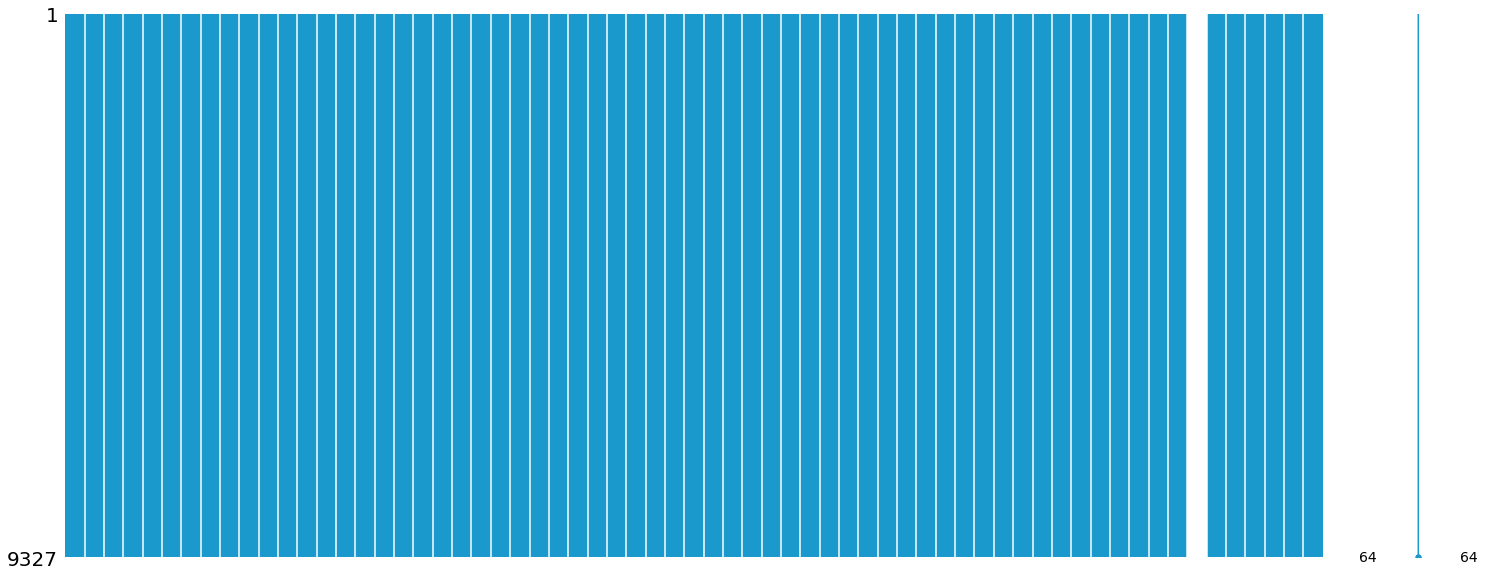

In [59]:
msno.matrix(train.iloc[:, :], color=(0.1, 0.6, 0.8))

In [16]:
train[['activity_class_5min','CONVERT(activity_class_5min USING utf8)']]

,activity_class_5min,CONVERT(activity_class_5min USING utf8)
0,...,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...
1,...,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...
2,...,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...
3,...,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...
4,...,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...
...,...,...
9322,...,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...
9323,...,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...
9324,...,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...
9325,...,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...


In [26]:
#col = 'activity_class_5min'
#col = 'activity_met_1min'
#col = 'sleep_hr_5min'
#col = 'sleep_hypnogram_5min'
col = 'sleep_rmssd_5min'
train[col].value_counts()

...    9327
Name: sleep_rmssd_5min, dtype: int64

In [62]:
test.head()

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_delta,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8)
0,nia+075@rowan.kr,2020-10-19,1.738393,627.0,2718.0,...,17125.461981,0.0,588.0,1,...,-0.022292,-0.346215,99.99,NaN,\r,1/1/1/1/1/1/1/1/2/1/1/1/1/1/1/1/1/1/1/1/1/1/2/...,1.4/1.8/1.2/3.9/0.9/0.1/0.9/0.9/1.3/1.2/0.9/0....,71/0/65/64/71/64/0/60/66/69/64/66/61/64/62/66/...,2/2/3/2/3/1/3/2/4/4/2/2/4/4/3/2/1/2/4//2/4/2/2...,44/19/19/16/0/20/32/26/13/14/25/17/22/25/17/14...
1,nia+075@rowan.kr,2020-10-20,1.442223,137.0,2672.0,...,11410.099490,0.0,544.0,1,...,0.481816,0.019516,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.6/0.9/0.9/1.3/3.9/2.9/0.9/0.9/0.9/1.1/0.9/1/...,65/56/56/60/59/58/59/58/57/59/62/60/59/56/54/5...,4/3/3/2/1/2/2/1/3/4/2/3/3/1/3/3/1/2/2/2/2/2/3/...,21/17/23//34/19/17/15/19/19/17/30/29/13/19/21/...
2,nia+075@rowan.kr,2020-10-21,1.479700,175.0,2514.0,...,5497.769969,2.0,559.0,2,...,-0.082092,0.022043,99.99,NaN,\r,1/1/1/1/1/2/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/1/...,1.5/0.9/1.4/0.9/0.9/0.9/3.6/1.5/0.9/0.9/0.9/1....,64/0/57/66/52/0/62/0/61/61/0/54/54/52/0/55/64/...,3/1/4/2/2/2/4/4/3/2/2/3/1/2/1/2/3/4/1/2/2/4/2/...,0/21/0/19/53/30/0/27/0/0/70/0/0/44/0/24/31/0/1...
3,nia+075@rowan.kr,2020-10-22,1.069079,217.0,2653.0,...,3852.789155,0.0,671.0,0,...,0.177269,0.013762,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,4.8/1.9/1/1.3/1.4/1.8//2.2/2.1/1.2/1.2/1.2/2.3...,61/61/63/64/59/62/59/60/62/63/58/65/64/61/61/6...,4/1/2/1/4/2/1/2/1/1/2/2/4/4/2/1/2/3/1/3/2/3/4/...,27/20/15/15/16/17/18/22/16/16/16/37/18/18/16/1...
4,nia+075@rowan.kr,2020-10-23,1.645156,16.0,2327.0,...,4483.044208,0.0,767.0,0,...,-0.037126,-0.110565,99.99,NaN,\r,1/1/1/1/1/2/1/1/2/2/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.9/1.4/1.2/1.3/1.4/1.7/1.2/1/1.8/1.2/0.9/0.9/...,58/0/60/57/60/63/57/55/56/57/57/0//57/58/56/58...,4/4/2/2/4/4/4/4/2/2/2/4/2/1/4/2/4//2/2/4/4/4/4...,25/33/13/19/14/29/25/19/0/22/0/29/0/37/0/27/0/...


In [66]:
# 정답값(label) 이 train data에 대해서만 존재 -> Issue! 
print(train['EMAIL'].nunique())
label

148


,SAMPLE_EMAIL,DIAG_NM
0,nia+315@rowan.kr,CN
1,nia+220@rowan.kr,CN
2,nia+096@rowan.kr,MCI
3,nia+163@rowan.kr,CN
4,nia+396@rowan.kr,CN
...,...,...
143,nia+394@rowan.kr,CN
144,nia+067@rowan.kr,Dem
145,nia+013@rowan.kr,MCI
146,nia+450@rowan.kr,CN


## dementia 2 

In [24]:
path = "./Dataset_dementia3/"
dementia =  pd.read_csv(path + "dementia_dataset.csv")

In [25]:
dementia

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [67]:
path = "./Dataset_alzheimers/"
cross =  pd.read_csv(path + "oasis_cross-sectional.csv")
longitude =  pd.read_csv(path + "oasis_longitudinal.csv")

In [68]:
cross

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
431,OAS1_0285_MR2,M,R,20,NaN,NaN,NaN,NaN,1469,0.847,1.195,2.0
432,OAS1_0353_MR2,M,R,22,NaN,NaN,NaN,NaN,1684,0.790,1.042,40.0
433,OAS1_0368_MR2,M,R,22,NaN,NaN,NaN,NaN,1580,0.856,1.111,89.0
434,OAS1_0379_MR2,F,R,20,NaN,NaN,NaN,NaN,1262,0.861,1.390,2.0


In [69]:
longitude

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


## 2. 중고차 가격 맞추기

**data : 426,880 × 26**
  
**column informations**

- feature column (2 -> 0)
    - id 
    - YIN : Vehicle Identification Number (차량 식별 번호)
- Inaccessible variable (4 -> 0)
    - url, region, region_url, img_url
- Continous variable 
    - year(연식), odometer(주행거리)
    - long, lat : but this data from US not Kor
- Categorical variable 
    - manufacturer(제조사), model(모델정보), cylinders, fuel, transmission(변속기), drive(구동종류), paint_color, type(차량종류)
    - size : 72% of the data is lost 
    - state(상장상태?)
    - posting_date(등록날짜) : why this car hasn't been sold for a long time? 
    - title_status(차량내부상태) : clean or not 
- Text variable (1)
    - description
- Null variable (1 -> 0)
    - county : caution! this is not 'country', all the values are null 
- **Y variable (2 -> 1)**
    - price -> Regression
    - price : 32,895 are 0 -> 393,985개 
    - condition -> Multi-class Classification (label:6)

So we may use 393,985 x 18 for training...
  
For more details https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

In [2]:
path = "./Dataset_usedcar/"
car =  pd.read_csv(path + "vehicles.csv")

In [3]:
car.tail(3)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,...,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,...,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600
426879,7301591129,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,...,NaN,coupe,NaN,https://images.craigslist.org/00Y0Y_lEUocjyRxa...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:07-0600


In [4]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

<AxesSubplot:>

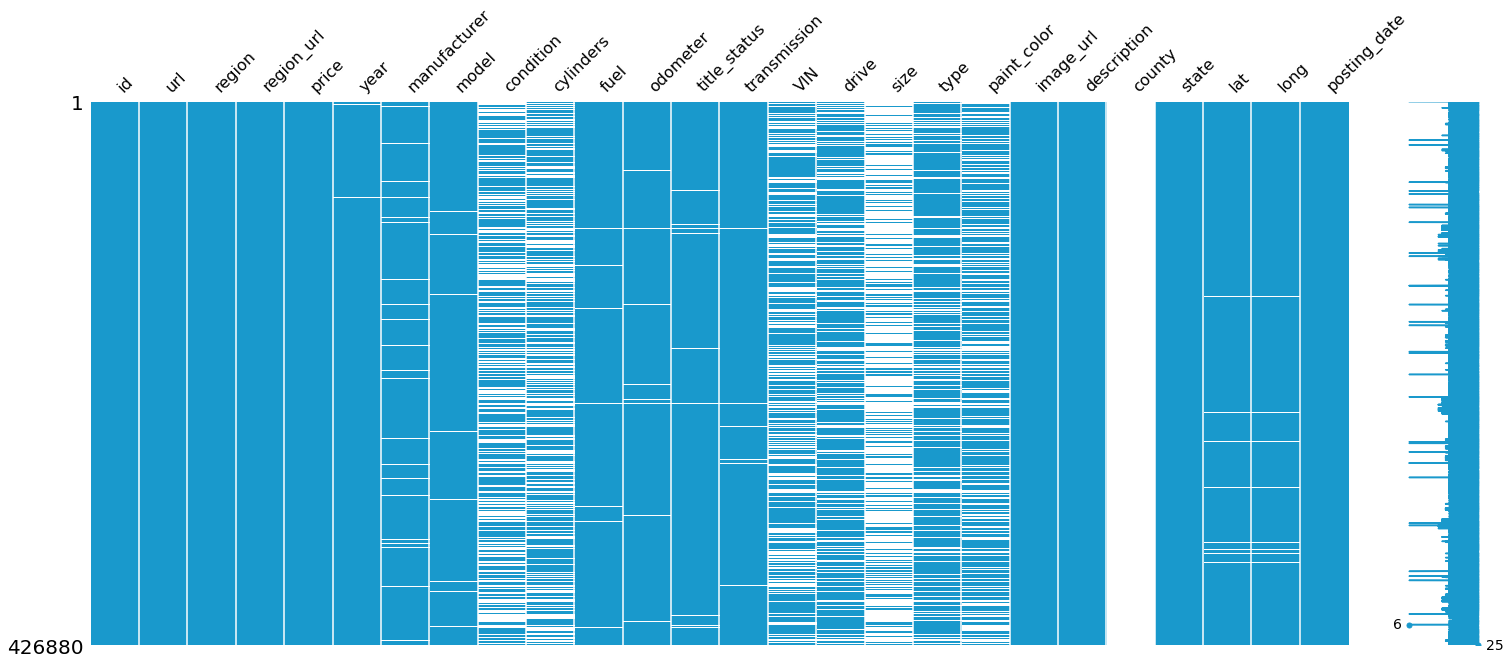

In [5]:
msno.matrix(car.iloc[:, :], color=(0.1, 0.6, 0.8))

In [17]:
state_of_listing = car['description']
state_of_listing.drop_duplicates()

0                                                       NaN
27        Carvana is the safer way to buy a car During t...
28        Carvana is the safer way to buy a car During t...
29        Carvana is the safer way to buy a car During t...
30        Carvana is the safer way to buy a car During t...
                                ...                        
426875    Carvana is the safer way to buy a car During t...
426876    Carvana is the safer way to buy a car During t...
426877    Carvana is the safer way to buy a car During t...
426878    Carvana is the safer way to buy a car During t...
426879    Carvana is the safer way to buy a car During t...
Name: description, Length: 360912, dtype: object

In [15]:
# label = 0원 : 32,895 
len(## 2. 중고차 가격 맞추기car['price'][car['price'] == 0])

32895

In [26]:
car['condition'].nunique()

6

## 3. 진짜 저스틴비버는 누구?

#### Issue
1. Instagram Graph API (또는 크롤링) 하는 거

**data : 10,319 × 13**
  
**column informations**
- feature variable (1 -> 0)
    - urls
- Continous variable (7)
    - From cpations columns or sns info 
    - n_like, n_comments, n_hashtags, n_characters, n_words, n_emojis, n_mentions
- Categorical variable (1) 
    - isvideo : False or True 
- date variable (1)
    - post_dates
- Text variable (1)
    - captions : 2,037 are null
- Image variable (1)
    - display_picture_relative_url
    - we may repalce this column with image data(10,319)
  
- **Y variable (1)**
    - username -> Multi-class Classification (label:5)
    
So we may use 10,319 × 11 for training...  
text, image, tabular data
  
For more details https://www.kaggle.com/datasets/aldiandyainf/which-justin-posted-that

In [19]:
path = "./Dataset_celebrity/"
celeb =  pd.read_csv(path + "dataset.csv")

In [21]:
celeb.head()

,username,urls,post_dates,display_picture_relative_url,captions,n_likes,n_comments,n_hashtags,n_characters,n_words,n_emojis,n_mentions,is_video
0,justinbieber,https://www.instagram.com/p/CbNn8XPrGZG,1647537136,./imgs/CbNn8XPrGZG.png,📷: @evanpaterakis,794012,3406,0,17,2,1,0,False
1,justinbieber,https://www.instagram.com/p/CbNnwOfLtow,1647537037,./imgs/CbNnwOfLtow.png,📷: @evanpaterakis,1172000,4955,0,17,2,1,0,False
2,justinbieber,https://www.instagram.com/p/CbNmvJErdhZ,1647536503,./imgs/CbNmvJErdhZ.png,📷 @rorykramer,760049,2952,0,13,2,1,0,False
3,justinbieber,https://www.instagram.com/p/CbNmjmkLVKg,1647536409,./imgs/CbNmjmkLVKg.png,📷: @rorykramer,1638370,6703,0,14,2,1,0,False
4,justinbieber,https://www.instagram.com/p/CbLpmoQPga5,1647470898,./imgs/CbLpmoQPga5.png,NaN,1529572,7517,0,0,0,0,1,False


In [23]:
celeb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10319 entries, 0 to 10318
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   username                      10319 non-null  object
 1   urls                          10319 non-null  object
 2   post_dates                    10319 non-null  int64 
 3   display_picture_relative_url  10319 non-null  object
 4   captions                      8282 non-null   object
 5   n_likes                       10319 non-null  int64 
 6   n_comments                    10319 non-null  int64 
 7   n_hashtags                    10319 non-null  int64 
 8   n_characters                  10319 non-null  int64 
 9   n_words                       10319 non-null  int64 
 10  n_emojis                      10319 non-null  int64 
 11  n_mentions                    10319 non-null  int64 
 12  is_video                      10319 non-null  bool  
dtypes: bool(1), int6

<AxesSubplot:>

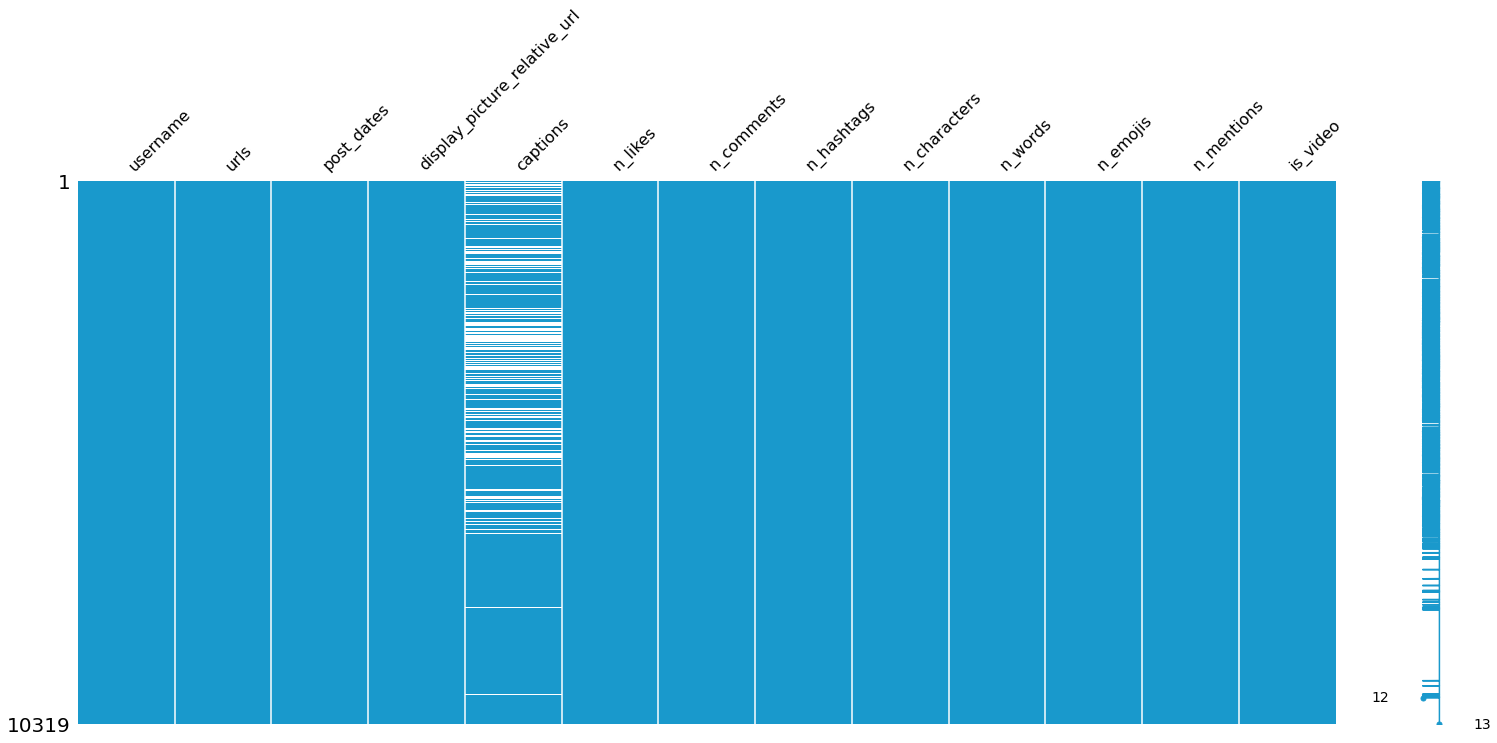

In [24]:
msno.matrix(celeb.iloc[:, :], color=(0.1, 0.6, 0.8))

In [27]:
celeb.username.nunique()

5

In [41]:
#n_likes	n_comments	n_hashtags(15)	n_characters(966)	n_words(292)	n_emojis	n_mentions
celeb.is_video.value_counts()

False    8446
True     1873
Name: is_video, dtype: int64

In [42]:
celeb.captions.isna().sum()

2037

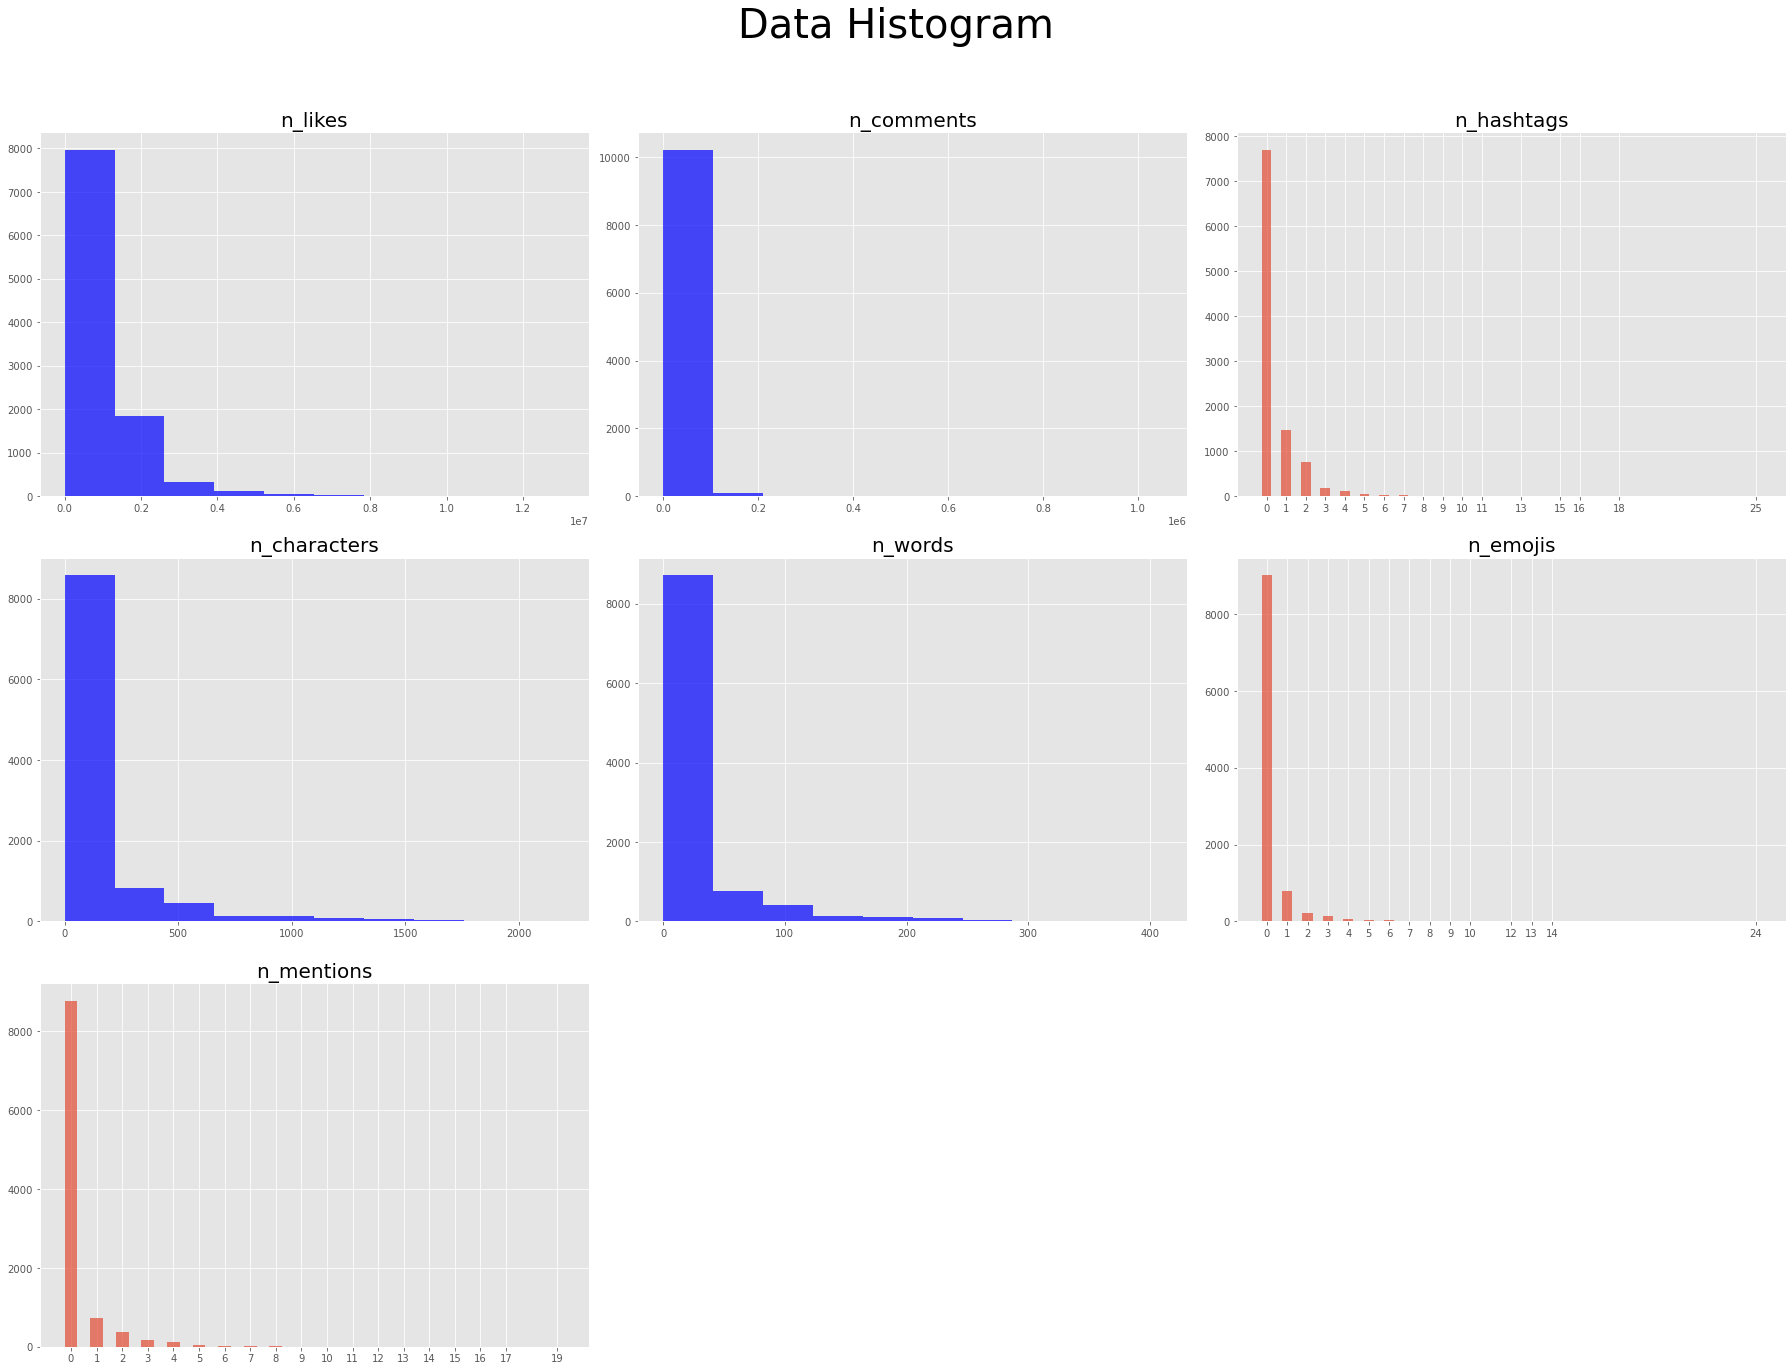

In [44]:
plt.style.use("ggplot")

# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,20))
plt.suptitle("Data Histogram", fontsize=40)

# id는 제외하고 시각화합니다.
cols = ['n_likes', 'n_comments', 'n_hashtags', 'n_characters', 'n_words', 'n_emojis', 'n_mentions']
for i in range(len(cols)):
    plt.subplot(3,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(celeb[cols[i]].unique()) > 20:
        plt.hist(celeb[cols[i]], color='b', alpha=0.7)
    else:
        temp = celeb[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. 생육 환경 최적화 경진대회 

**data : 12,960 × 19 x 75 set**
  
**column informations**
  
- **Y variable (1)**
    - leaf weight -> Regression?? 
    - label csv 따로 존재
    
So we may use 14,250,000 (75 case x 10,000) for training...  
image, timeseries data...
  
For more details https://dacon.io/competitions/official/235897/data

In [48]:
path = "./Dataset_dacon/train/CASE01/meta"
file_list = os.listdir(path) 

plant_df_list = []
for i in file_list:
    plant_df_list.append(pd.read_csv(path +"/"+ i))

print(type(plant_df_list[0])) 

<class 'pandas.core.frame.DataFrame'>


In [50]:
plant = pd.DataFrame()

for i in plant_df_list:
    plant = pd.concat([plant, i], ignore_index= True)

plant_df.head()

,시간,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-05-07 02:46,18.6,41.500000,77.599998,NaN,582.0,18.600000,0.0,201.0,201.0,201.0,14.0,0.0,15.0,13.000002,0.0,0.0,0.0,NaN
1,2021-05-07 02:47,18.6,41.500000,77.699997,0.0,585.0,18.799999,0.0,201.0,201.0,0.0,14.0,0.0,15.0,13.000002,0.0,0.0,0.0,NaN
2,2021-05-07 02:48,18.6,41.299999,77.800003,0.0,587.0,18.700001,0.0,201.0,201.0,NaN,14.0,0.0,15.0,13.000002,0.0,0.0,0.0,NaN
3,2021-05-07 02:49,18.5,41.099998,77.800003,0.0,584.0,18.799999,0.0,201.0,201.0,0.0,14.0,0.0,15.0,12.500000,0.0,0.0,0.0,NaN
4,2021-05-07 02:50,18.6,41.200001,77.800003,0.0,583.0,19.100000,0.0,201.0,201.0,0.0,14.0,0.0,15.0,13.000002,0.0,0.0,0.0,NaN


In [51]:
plant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           12960 non-null  object 
 1   내부온도관측치      12957 non-null  float64
 2   외부온도관측치      12958 non-null  float64
 3   내부습도관측치      12958 non-null  float64
 4   외부습도관측치      10360 non-null  float64
 5   CO2관측치       12958 non-null  float64
 6   EC관측치        12958 non-null  float64
 7   최근분무량        12960 non-null  float64
 8   화이트 LED동작강도  12513 non-null  float64
 9   레드 LED동작강도   12502 non-null  float64
 10  블루 LED동작강도   7741 non-null   float64
 11  냉방온도         12745 non-null  float64
 12  냉방부하         12745 non-null  float64
 13  난방온도         12745 non-null  float64
 14  난방부하         12744 non-null  float64
 15  총추정광량        12745 non-null  float64
 16  백색광추정광량      12745 non-null  float64
 17  적색광추정광량      12745 non-null  float64
 18  청색광추정광량      0 non-null      float64
dtypes: f

<AxesSubplot:>

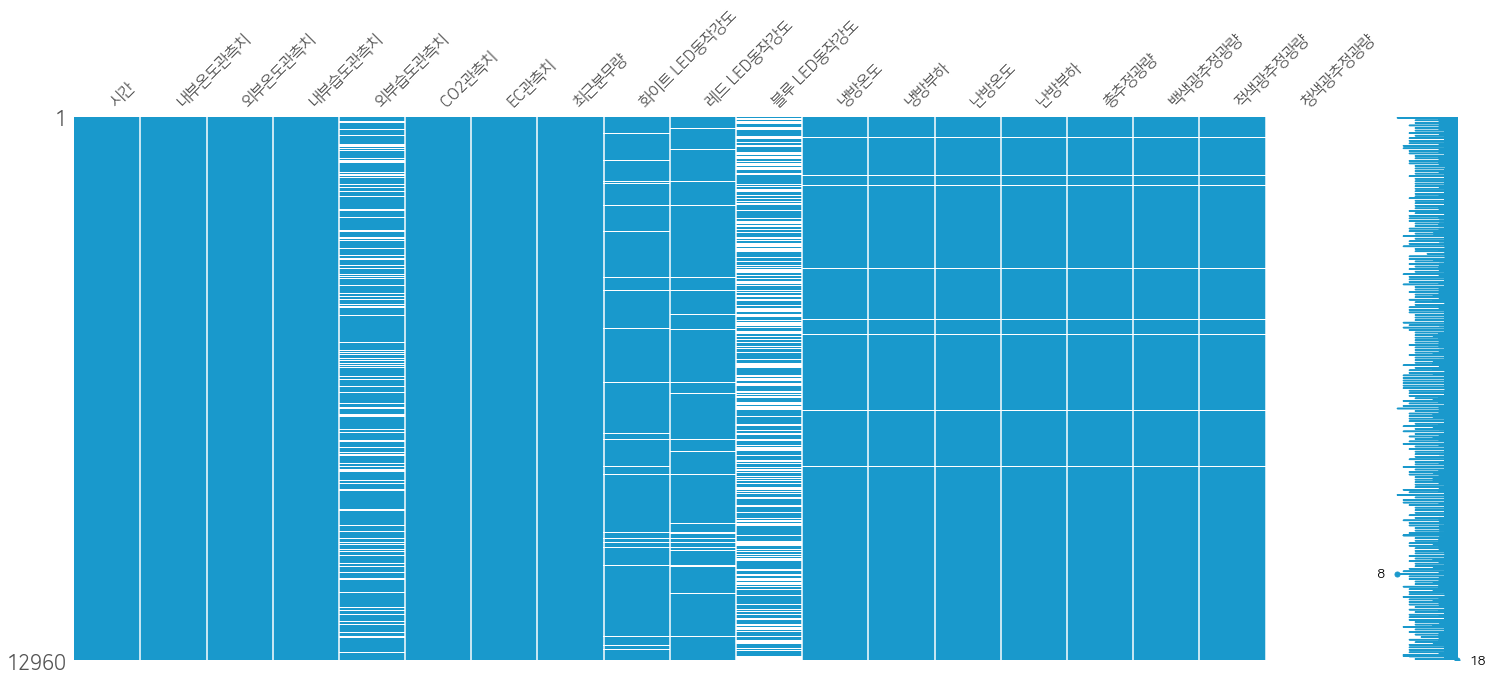

In [59]:
msno.matrix(plant.iloc[:, :], color=(0.1, 0.6, 0.8))

In [52]:
plant.isnull().sum()

시간                 0
내부온도관측치            3
외부온도관측치            2
내부습도관측치            2
외부습도관측치         2600
CO2관측치             2
EC관측치              2
최근분무량              0
화이트 LED동작강도      447
레드 LED동작강도       458
블루 LED동작강도      5219
냉방온도             215
냉방부하             215
난방온도             215
난방부하             216
총추정광량            215
백색광추정광량          215
적색광추정광량          215
청색광추정광량        12960
dtype: int64

In [54]:
plant_df.describe()

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
count,12957.000000,12958.000000,12958.000000,10360.000000,12958.000000,12958.000000,12960.0,12513.000000,12502.000000,7741.000000,12745.000000,12745.000000,12745.000000,12744.000000,12745.000000,12745.000000,12745.000000,0.0
mean,23.315860,55.387977,80.211252,4.559749,493.834465,21.419069,0.0,200.647487,200.727324,0.233691,17.416541,179.493030,18.854038,15.967032,145.995394,12.380553,21.117084,NaN
std,4.463229,14.523160,3.853566,29.928707,106.669787,3.533547,0.0,8.400044,7.389857,6.850058,4.383593,181.177762,4.800930,11.809581,146.310170,14.044855,24.020546,NaN
min,16.500000,23.000000,42.799999,0.000000,334.000000,14.500000,0.0,0.000000,0.000000,0.000000,14.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,19.000000,45.599998,78.400002,0.000000,388.000000,18.400000,0.0,201.000000,201.000000,0.000000,14.000000,0.000000,15.000000,9.499998,0.000000,0.000000,0.000000,NaN
50%,22.500000,55.900002,80.699997,0.000000,495.000000,21.000000,0.0,201.000000,201.000000,0.000000,14.000173,111.769200,15.428883,11.999998,95.917100,6.619200,6.266000,NaN
75%,27.500000,66.500000,82.900002,0.000000,588.000000,23.700001,0.0,201.000000,201.000000,0.000000,23.996412,376.174300,25.996213,21.999998,309.410000,23.167200,48.561500,NaN
max,32.099998,89.400002,89.900002,201.000000,684.000000,30.900000,0.0,201.000000,201.000000,201.000000,24.000000,401.944700,26.000000,58.484915,309.410000,47.989200,61.093500,NaN


In [55]:
plant_df.describe(include='O')

,시간
count,12960
unique,12960
top,2021-05-09 03:15
freq,1


array([[<AxesSubplot:title={'center':'내부온도관측치'}>,
        <AxesSubplot:title={'center':'외부온도관측치'}>,
        <AxesSubplot:title={'center':'내부습도관측치'}>,
        <AxesSubplot:title={'center':'외부습도관측치'}>],
       [<AxesSubplot:title={'center':'CO2관측치'}>,
        <AxesSubplot:title={'center':'EC관측치'}>,
        <AxesSubplot:title={'center':'최근분무량'}>,
        <AxesSubplot:title={'center':'화이트 LED동작강도'}>],
       [<AxesSubplot:title={'center':'레드 LED동작강도'}>,
        <AxesSubplot:title={'center':'블루 LED동작강도'}>,
        <AxesSubplot:title={'center':'냉방온도'}>,
        <AxesSubplot:title={'center':'냉방부하'}>],
       [<AxesSubplot:title={'center':'난방온도'}>,
        <AxesSubplot:title={'center':'난방부하'}>,
        <AxesSubplot:title={'center':'총추정광량'}>,
        <AxesSubplot:title={'center':'백색광추정광량'}>],
       [<AxesSubplot:title={'center':'적색광추정광량'}>,
        <AxesSubplot:title={'center':'청색광추정광량'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


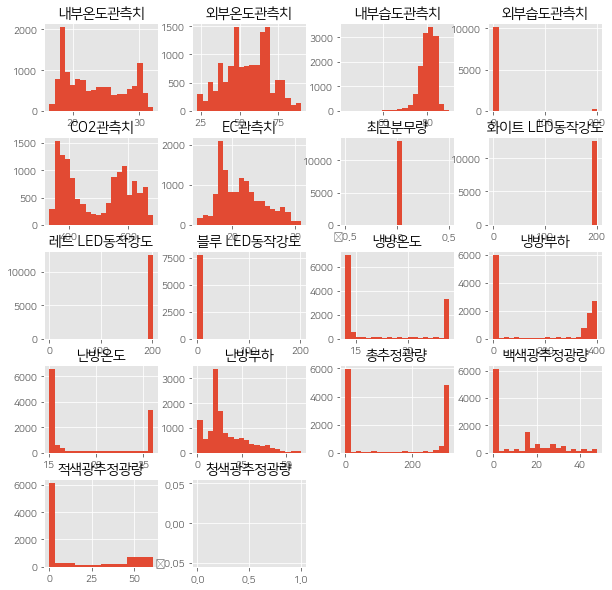

In [58]:
plant_df.hist(bins= 20, figsize =(10,10))